In [1]:
# Default Loads
import pandas as pd
import numpy as np
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.options.display.float_format = '{:.4f}'.format

#No SK-Learn Loads
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lg

#SK Learn Loads
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score

#Plotting Loads
import matplotlib.pyplot as plt
import seaborn as sb

#Deep Learning Loads
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# IGNORE Warnings
import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


# The below functions and classes will be used later in the notebook

## The below class was borrowed from the sample notebook 

In [2]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

## The following function will help us load the train dataset. 
* We have engineered  6 features here

In [3]:
def load_main_files(filename =""):
        df_train = pd.read_csv(filename)
        df_train.index = df_train['SK_ID_CURR']

        # Converting days to years and removing outliers
        df_train[df_train.columns[df_train.columns.str.contains('DAYS')]] = abs(
            df_train[df_train.columns[df_train.columns.str.contains('DAYS')]]).replace(365243, np.nan)/365

        # Naimesh Features
        df_train['income_credit_percen'] = (
            df_train.AMT_INCOME_TOTAL / df_train.AMT_CREDIT).replace(np.inf, 0)
        df_train['fam_member_income'] = (
            df_train.AMT_INCOME_TOTAL / df_train.CNT_FAM_MEMBERS).replace(np.inf, 0)
        df_train['ann_incom_percen'] = (
            df_train.AMT_ANNUITY / df_train.AMT_INCOME_TOTAL).replace(np.inf, 0)

        # Nishad Features
        df_train['new_employ_to_birth_ratio'] = (
            df_train.DAYS_EMPLOYED / df_train.DAYS_BIRTH).replace(np.inf, 0)
        df_train['new_credit_to_annuity'] = (
            df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY']).replace(np.inf, 0)
        df_train['new_credit_to_goods_ratio'] = (
            df_train['AMT_CREDIT'] / df_train['AMT_GOODS_PRICE']).replace(np.inf, 0)
        df_train['new_car_to_birth_ratio'] = (
            df_train['OWN_CAR_AGE'] / df_train['DAYS_BIRTH']).replace(np.inf, 0)
        df_train['new_car_to_emp_ratio'] = (
            df_train['OWN_CAR_AGE'] / df_train['DAYS_EMPLOYED']).replace(np.inf, 0)
        df_train['new_inc_per_child'] = (
            df_train['AMT_INCOME_TOTAL'] / (1 + df_train['CNT_CHILDREN'])).replace(np.inf, 0)

        selected_features = ['SK_ID_CURR', 'AMT_INCOME_TOTAL',  'AMT_CREDIT', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_1',
                             'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR',
                             'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE',
                             'income_credit_percen', 'fam_member_income', 'ann_incom_percen', 'new_employ_to_birth_ratio',
                             'new_credit_to_annuity', 'new_credit_to_goods_ratio', 'new_car_to_birth_ratio', 'new_car_to_emp_ratio',
                             'new_inc_per_child']

        X_train = df_train[selected_features]
        
        
        if filename == 'application_train.csv':
            y_train = df_train['TARGET']

            X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)
            X_train, X_test, y_train, y_test = train_test_split(
                X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

            X_valid.index = X_valid['SK_ID_CURR']
            
            X_train.index = X_train['SK_ID_CURR']
            X_test.index = X_test['SK_ID_CURR']
            X_valid.drop('SK_ID_CURR', inplace=True, axis=1)
            X_test.drop('SK_ID_CURR', inplace=True, axis=1)
            X_train.drop('SK_ID_CURR', inplace=True, axis=1)
            return  X_train, y_train, X_valid, y_valid, X_test, y_test

        else:
            X_train.index = X_train['SK_ID_CURR']
            X_train.drop('SK_ID_CURR', inplace=True, axis=1)
            return X_train




## The following class will help us merge all auxilary files

In [4]:
class merge_df(BaseEstimator, TransformerMixin):
    def __init__(self, dflist):
        self.dflist = dflist
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self,X, y = None):
        for f in self.dflist:
            X = X.merge(f, how='left', on='SK_ID_CURR')
        X.fillna(0, inplace=True)
        
        return X


## The following function will help us transform the train dataset

In [5]:
class transform_train(BaseEstimator, TransformerMixin):
    def __init__(self, num_attribs, cat_attribs):
        self.Nattrib = num_attribs
        self.Cattrib = cat_attribs
        self.num_pipeline = Pipeline([
            ('selector', DataFrameSelector(self.Nattrib)),
            ('imputer', SimpleImputer(strategy='mean')),
            ('std_scaler', StandardScaler()),
        ])
        self.cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(self.Cattrib)),
            ('imputer', SimpleImputer(strategy='constant')),
            ('ohe', OneHotEncoder(
                sparse=False, handle_unknown="ignore"))
        ])
        self.data_prep_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", self.num_pipeline),
            ("cat_pipeline", self.cat_pipeline),
        ])

        self.full_pipeline = Pipeline(
            [("preparation", self.data_prep_pipeline)])

    def fit(self, X, y=None):
        self.full_pipeline.fit(X)
        return self

    def transform(self, X, y=None):
        X_trans = pd.DataFrame(self.full_pipeline.transform(X), index=X.index)

        cat_cols = list(self.full_pipeline.named_steps['preparation'].transformer_list[1]
                        [1].named_steps['ohe'].get_feature_names(self.Cattrib))

        X_trans.columns = self.Nattrib + cat_cols

        return X_trans

    def fit_transform(self, X, y=None):
        self.full_pipeline.fit(X)

        X_ftrans = pd.DataFrame(self.full_pipeline.transform(X), index=X.index)

        cat_cols = list(self.full_pipeline.named_steps['preparation'].transformer_list[1]
                        [1].named_steps['ohe'].get_feature_names(self.Cattrib))

        X_ftrans.columns = self.Nattrib + cat_cols

        return X_ftrans
    
    def get_features(self):
            cat_cols = list(self.full_pipeline.named_steps['preparation'].transformer_list[1]
                    [1].named_steps['ohe'].get_feature_names(self.Cattrib))
            final = self.Nattrib + cat_cols
            return final


## The Following function will help us update our expirement Log

In [6]:
 def update_log(expLog, exp_name, model, X_train, y_train, X_test, y_test, X_valid, y_valid):
    p_value = 0
    expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
        [accuracy_score(y_train, model.predict(X_train)),
         accuracy_score(y_valid, model.predict(X_valid)),
         accuracy_score(y_test, model.predict(X_test)),
         roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
         roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
         roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), p_value],
        4))
    return expLog

## The bellow function will help us aggregate all auxiliary file except the ones related to bureau.
* We have engineered two manual features here. There is potential to add many more for the different files
* Rest of the features are engineered via automated programming. For each field we will take the mean, sum, and count

In [7]:
def agg_files_set(file="", pre=""):
    if file != "":
        df_pa = pd.read_csv(file)
        df_pa.index = df_pa['SK_ID_CURR']
        df_pa.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis=1, inplace=True)

        # Individual File Feature Will Go Here
        if file == 'previous_application.csv':
            df_pa['AppToCredit'] = (
                df_pa.AMT_APPLICATION/df_pa.AMT_CREDIT).replace(np.inf, 0)
            df_pa['DownToCredit'] = (
                df_pa.AMT_DOWN_PAYMENT/df_pa.AMT_CREDIT).replace(np.inf, 0)

        numcols = df_pa.select_dtypes(exclude='object').columns
        catcols = df_pa.select_dtypes(include='object').columns

        num = df_pa[numcols]
        cat = df_pa[catcols]

        num = num.groupby('SK_ID_CURR').agg([np.sum, np.mean, 'count'])
        num.columns = num.columns.map('_'.join)
        mdl = StandardScaler().fit(num)
        num = pd.DataFrame(mdl.transform(
            num), index=num.index, columns=num.columns)

        if len(catcols) != 0:

            catt = SimpleImputer(strategy='constant').fit_transform(cat)
            mdl = OneHotEncoder().fit(catt)
            cat = pd.DataFrame(mdl.transform(catt).toarray(
            ), index=cat.index, columns=list(mdl.get_feature_names(catcols)))
            cat = cat.groupby('SK_ID_CURR').agg(np.mean)
            final = num.merge(cat, how='left', on='SK_ID_CURR')
        else:
            final = num

        final = final.add_prefix(pre)
        return final
    return "No File"


## The below function will help us aggregate the bureau files

In [8]:
def bur_balance():
    bur_bal = pd.read_csv('bureau_balance.csv')
    bur_bal.index = bur_bal['SK_ID_BUREAU']
    bur_bal.drop('SK_ID_BUREAU', inplace = True, axis = 1)
    numcols = bur_bal.select_dtypes(exclude='object').columns
    catcols = bur_bal.select_dtypes(include='object').columns

    num = bur_bal[numcols]
    cat = bur_bal[catcols]


    num = pd.DataFrame(SimpleImputer(strategy = 'mean').fit_transform(num), columns = num.columns, index = num.index)
    num = num.groupby('SK_ID_BUREAU').agg([np.sum, np.mean, 'count'])
    num.columns = num.columns.map('_'.join)

    if len(catcols) != 0:
        catt = SimpleImputer(strategy='constant').fit_transform(cat)
        mdl = OneHotEncoder().fit(catt)
        cat = pd.DataFrame(mdl.transform(catt).toarray(
        ), index=cat.index, columns=list(mdl.get_feature_names(catcols)))
        cat = cat.groupby('SK_ID_BUREAU').agg(np.mean)
        bur_final = num.merge(cat, how='left', on='SK_ID_BUREAU')
    else:
        bur_final = num

    bur_final = bur_final.add_prefix("bu_bal_")
    return bur_final

In [9]:
def bureau():
    bur = pd.read_csv('bureau.csv')
    bur_final =  bur_balance()
    bur = bur.merge(bur_final , how='left', on='SK_ID_BUREAU')
    bur.index = bur['SK_ID_CURR']
    bur.drop(['SK_ID_CURR','SK_ID_BUREAU'], axis = 1, inplace = True)
    
    numcols = bur.select_dtypes(exclude='object').columns
    catcols = bur.select_dtypes(include='object').columns

    num = bur[numcols]
    cat = bur[catcols]

    num = pd.DataFrame(SimpleImputer(strategy = 'mean').fit_transform(num), columns = num.columns, index = num.index)
    num = num.groupby('SK_ID_CURR').agg([np.sum, np.mean, 'count'])
    num.columns = num.columns.map('_'.join)
    mdl = StandardScaler().fit(num)
    num = pd.DataFrame(mdl.transform(
        num), index=num.index, columns=num.columns)

    if len(catcols) != 0:

        catt = SimpleImputer(strategy='constant').fit_transform(cat)
        mdl = OneHotEncoder().fit(catt)
        cat = pd.DataFrame(mdl.transform(catt).toarray(
        ), index=cat.index, columns=list(mdl.get_feature_names(catcols)))
        cat = cat.groupby('SK_ID_CURR').agg(np.mean)
        final = num.merge(cat, how='left', on='SK_ID_CURR')
    else:
        final = num
      
    final = final.add_prefix("BU_")
    return final



# Exploratory Data Analysis

In [10]:
df = pd.read_csv('application_train.csv')
df['DAYS_BIRTH'] = round(abs(df['DAYS_BIRTH'])/365).astype(int)
df['DAYS_EMPLOYED'] = round(abs(df['DAYS_EMPLOYED'])/365).astype(int)
df['TARGET'].replace(0, "No Default", inplace=True)
df['TARGET'].replace(1, "Default", inplace=True)

## Categorical Variables
* Imbalanced Dataset
* More Females then Males
* Most people own realty but not cars
* Most of the loan request were cash loans
* Most people had some sort of secondary or higher education
* Occupation type is wide spread but laborers are the highest.
* Highest income type is working

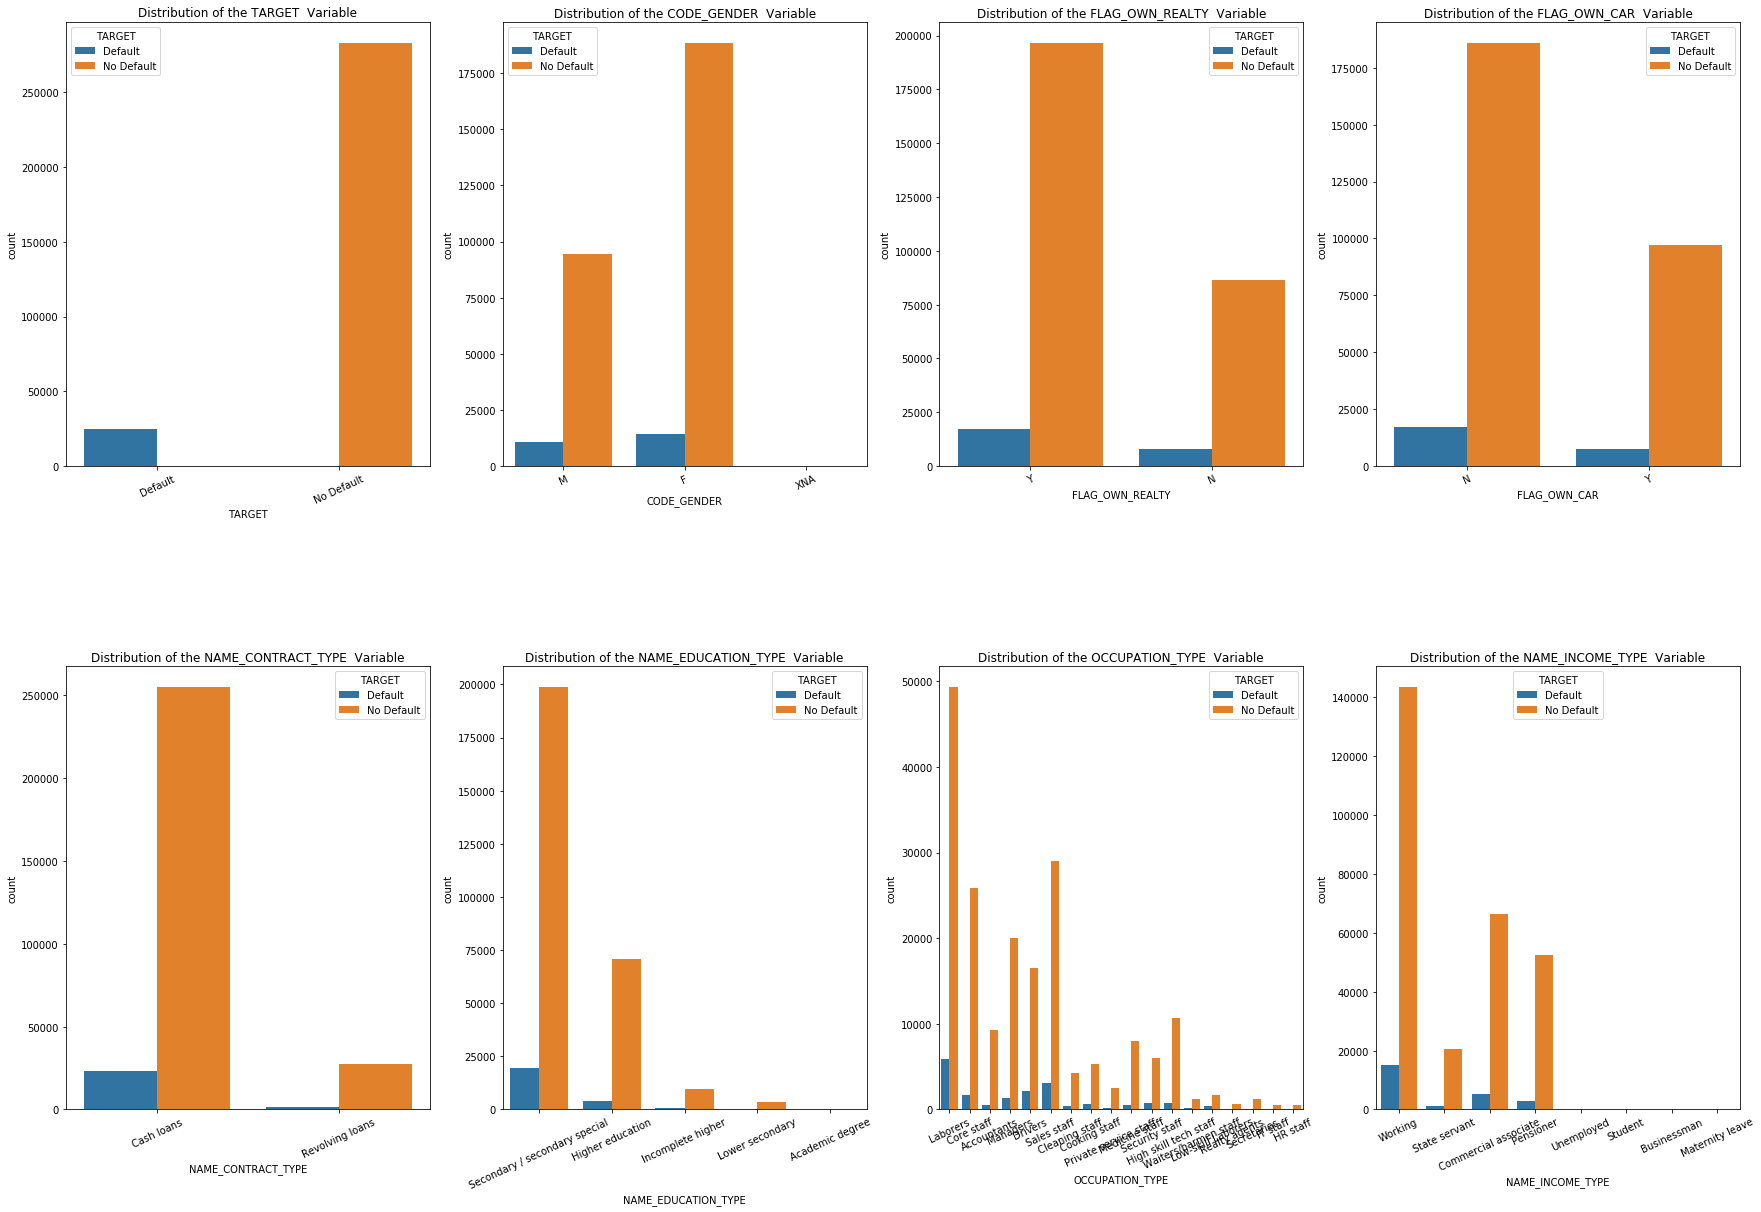

In [11]:
cat_attribs = ['TARGET', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
               'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE']
fig, ax = plt.subplots(2, 4, figsize=(30, 20))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.45)
num = 0
for i in range(0, 2):
    for j in range(0, 4):
        tst = sb.countplot(x=cat_attribs[num],
                           data=df, hue='TARGET', ax=ax[i][j])
        tst.set_title(f"Distribution of the {cat_attribs[num]}  Variable")
        tst.set_xticklabels(tst.get_xticklabels(), rotation=25)
        num = num + 1


## Numerical Variables
* Highest income value defaulted
* People in 60's/70's tend to default more
* Need to clean up days employed, no one is aged 1001 years old
* Non-Defaulters tend to have a higher EXT-Source 2 & 3
* No Strong variable correlation
* Amount Good Price and Amount Credit have a very strong linear relationship

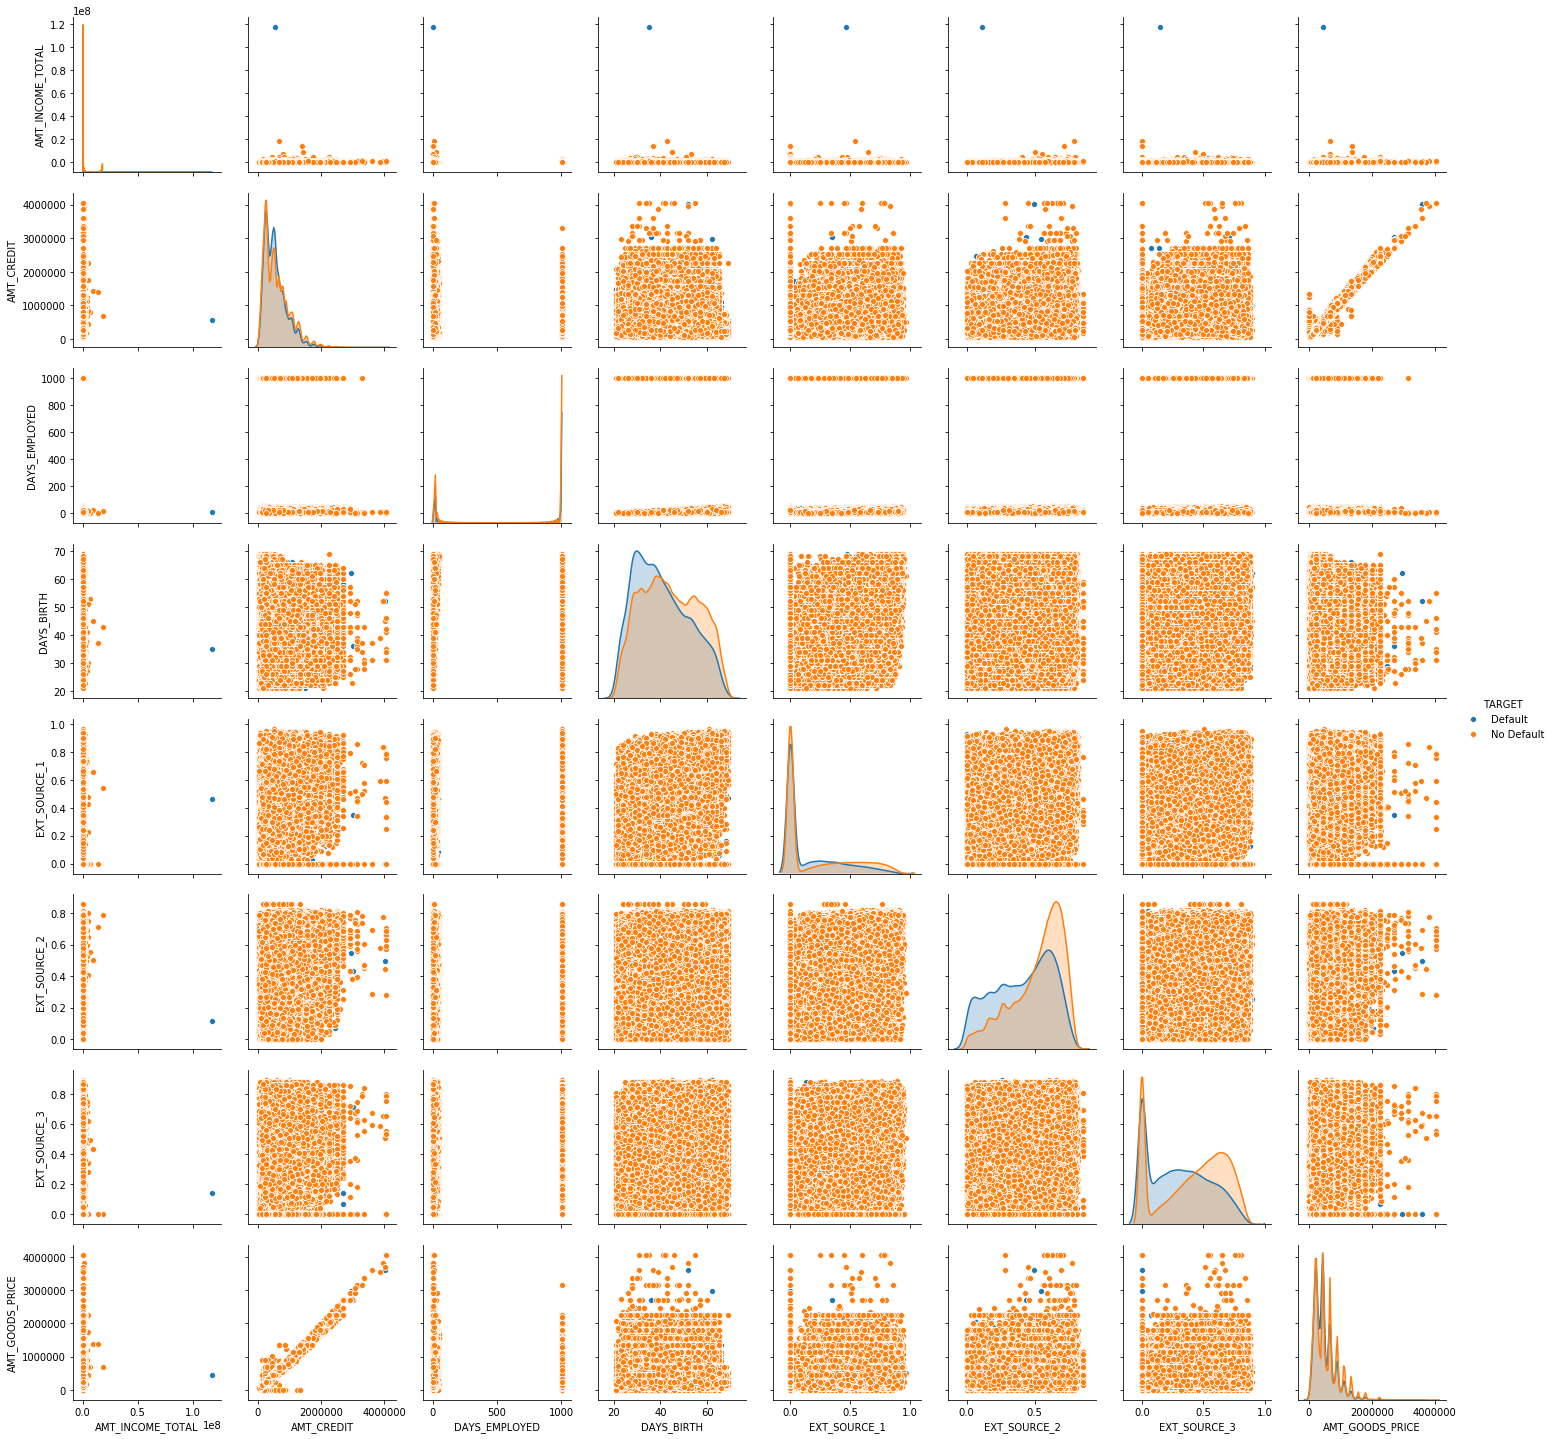

In [12]:
run = True  # Set this to true if you would ike to run, else just leave it. Take 5 mins to run
if run == True:
    num_attribs = ['TARGET', 'AMT_INCOME_TOTAL',  'AMT_CREDIT', 'DAYS_EMPLOYED',
                   'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_GOODS_PRICE']
    df2 = df[num_attribs]
    df2['TARGET'].replace(0, "No Default", inplace=True)
    df2['TARGET'].replace(1, "Default", inplace=True)
    df2.fillna(0, inplace=True)
    sb.pairplot(df2, hue="TARGET")


### Correlation Map of Numerical Variables
* Strong correlation between amount credit and amount goods price
* Strong correlation between days birth and days employed
* strong correlation between ext source 1 and days birth

These might be good candidates to do some feature engineering in. 

In [13]:
num_attribs = ['TARGET', 'AMT_INCOME_TOTAL',  'AMT_CREDIT', 'DAYS_EMPLOYED',
               'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_GOODS_PRICE']
df2 = df[num_attribs]
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_EMPLOYED,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_GOODS_PRICE
AMT_INCOME_TOTAL,1,0.16,-0.064,-0.027,0.026,0.061,-0.03,0.16
AMT_CREDIT,0.16,1,-0.064,0.055,0.17,0.13,0.044,0.99
DAYS_EMPLOYED,-0.064,-0.064,1,0.62,0.3,-0.018,0.12,-0.062
DAYS_BIRTH,-0.027,0.055,0.62,1,0.6,0.092,0.21,0.053
EXT_SOURCE_1,0.026,0.17,0.3,0.6,1,0.21,0.19,0.18
EXT_SOURCE_2,0.061,0.13,-0.018,0.092,0.21,1,0.11,0.14
EXT_SOURCE_3,-0.03,0.044,0.12,0.21,0.19,0.11,1,0.048
AMT_GOODS_PRICE,0.16,0.99,-0.062,0.053,0.18,0.14,0.048,1


# Loading Train Dataset & Splitting Into Train Valid & Test

In [14]:
expLog = pd.DataFrame(columns=["exp_name",
                               "Train Acc",
                               "Valid Acc",
                               "Test  Acc",
                               "Train AUC",
                               "Valid AUC",
                               "Test  AUC",
                               "P_Value"
                               ])

X_train, y_train, X_valid, y_valid, X_test, y_test = load_main_files(filename = "application_train.csv")


## Getting Baseline Score Logistic Regression

In [15]:
num_attribs = ['AMT_INCOME_TOTAL',  'AMT_CREDIT', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
               'income_credit_percen', 'fam_member_income', 'ann_incom_percen', 'new_employ_to_birth_ratio',
               'new_credit_to_annuity', 'new_credit_to_goods_ratio', 'new_car_to_birth_ratio', 'new_car_to_emp_ratio',
               'new_inc_per_child']

cat_attribs = ['CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
               'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE']

basepipe = Pipeline([
    ('tran', transform_train(num_attribs,cat_attribs))
   ,('mdl', LogisticRegression(n_jobs=-1, solver='lbfgs') )
])

basepipe.fit(X_train,y_train)
expLog = update_log(expLog, 'LogisticBase',basepipe, X_train, y_train, X_test, y_test, X_valid, y_valid)
expLog


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000


## Getting Baseline Score LightGBM

In [16]:
params = {
    'n_estimators': 1000, 'learning_rate': 0.1, 'n_jobs': -1
}

lgbmbase = Pipeline([
    ('tran', transform_train(num_attribs,cat_attribs))
   ,('mdl',  lg.LGBMClassifier(**params))
])

lgbmbase.fit(X_train,y_train)
expLog = update_log(expLog, 'LightGBM - No Additional Files- ',lgbmbase, X_train, y_train, X_test, y_test, X_valid, y_valid)
expLog



,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000
1,LightGBM - No Additional Files-,0.9318,0.9188,0.9187,0.9408,0.7547,0.7529,0.0000


# Loading all auxiliary files to the train test & valid set

In [17]:
df_pv_app = agg_files_set('previous_application.csv', 'PA_')
df_pos_app = agg_files_set('POS_CASH_balance.csv', 'POS_')
df_ins_pay = agg_files_set('installments_payments.csv', 'IP_')
df_credit_pay = agg_files_set('credit_card_balance.csv', 'CC_')
df_bureau = bureau()
lst = [df_pv_app, df_pos_app, df_ins_pay, df_credit_pay, df_bureau]

## Auxiliary files have been aggregate with metrics [Mean, Count, SUM]

## Adding all auxiliary files to the train test & valid set & training LightGBM model

In [18]:
#Had to split pipeline because we needed validation set to be transformed
#so that we can use it under eval metrics

params = {
    'n_estimators': 1000, 'learning_rate': 0.1, 'n_jobs': -1
}
TransPipe = Pipeline([
    ('tran', transform_train(num_attribs,cat_attribs))
   ,('merge', merge_df(lst))]) 

TransPipe.fit(X_train,y_train)


X_train_t = TransPipe.transform(X_train)
X_valid_t = TransPipe.transform(X_valid)
X_test_t = TransPipe.transform(X_test)


mdl = lg.LGBMClassifier(**params) 
mdl.fit(X_train_t , y_train
        ,eval_set=[(X_train_t , y_train),(X_test_t, y_test),(X_valid_t , y_valid)]
        ,eval_metric=['logloss', 'auc']
        ,early_stopping_rounds=100
        ,verbose=False)
       

expLog = update_log(expLog, 'LightGBM - All Files- ',mdl, X_train_t, y_train, X_test_t, y_test, X_valid_t, y_valid)

expLog


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000
1,LightGBM - No Additional Files-,0.9318,0.9188,0.9187,0.9408,0.7547,0.7529,0.0000
2,LightGBM - All Files-,0.9221,0.9200,0.9200,0.8280,0.7792,0.7781,0.0000


## 77% Valid & Test AUC Not Bad

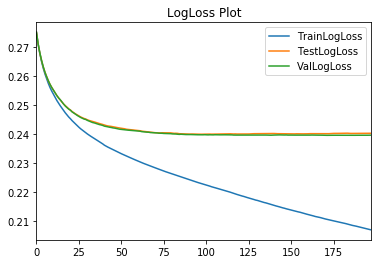

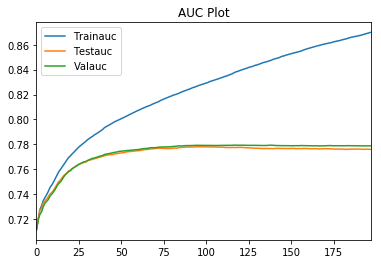

In [19]:
lg_model = mdl
evals_result = lg_model.evals_result_
evals = pd.DataFrame(evals_result['training']
                     ['binary_logloss'], columns=['TrainLogLoss'])
evals['TestLogLoss'] = evals_result['valid_1']['binary_logloss']
evals['ValLogLoss'] = evals_result['valid_2']['binary_logloss']
evals.plot(title="LogLoss Plot")


auc = pd.DataFrame(evals_result['training']['auc'], columns=['Trainauc'])
auc['Testauc'] = evals_result['valid_1']['auc']
auc['Valauc'] = evals_result['valid_2']['auc']
auc.plot(title="AUC Plot")

# Lets see if we can improve accuracy by selecting an lower set of features

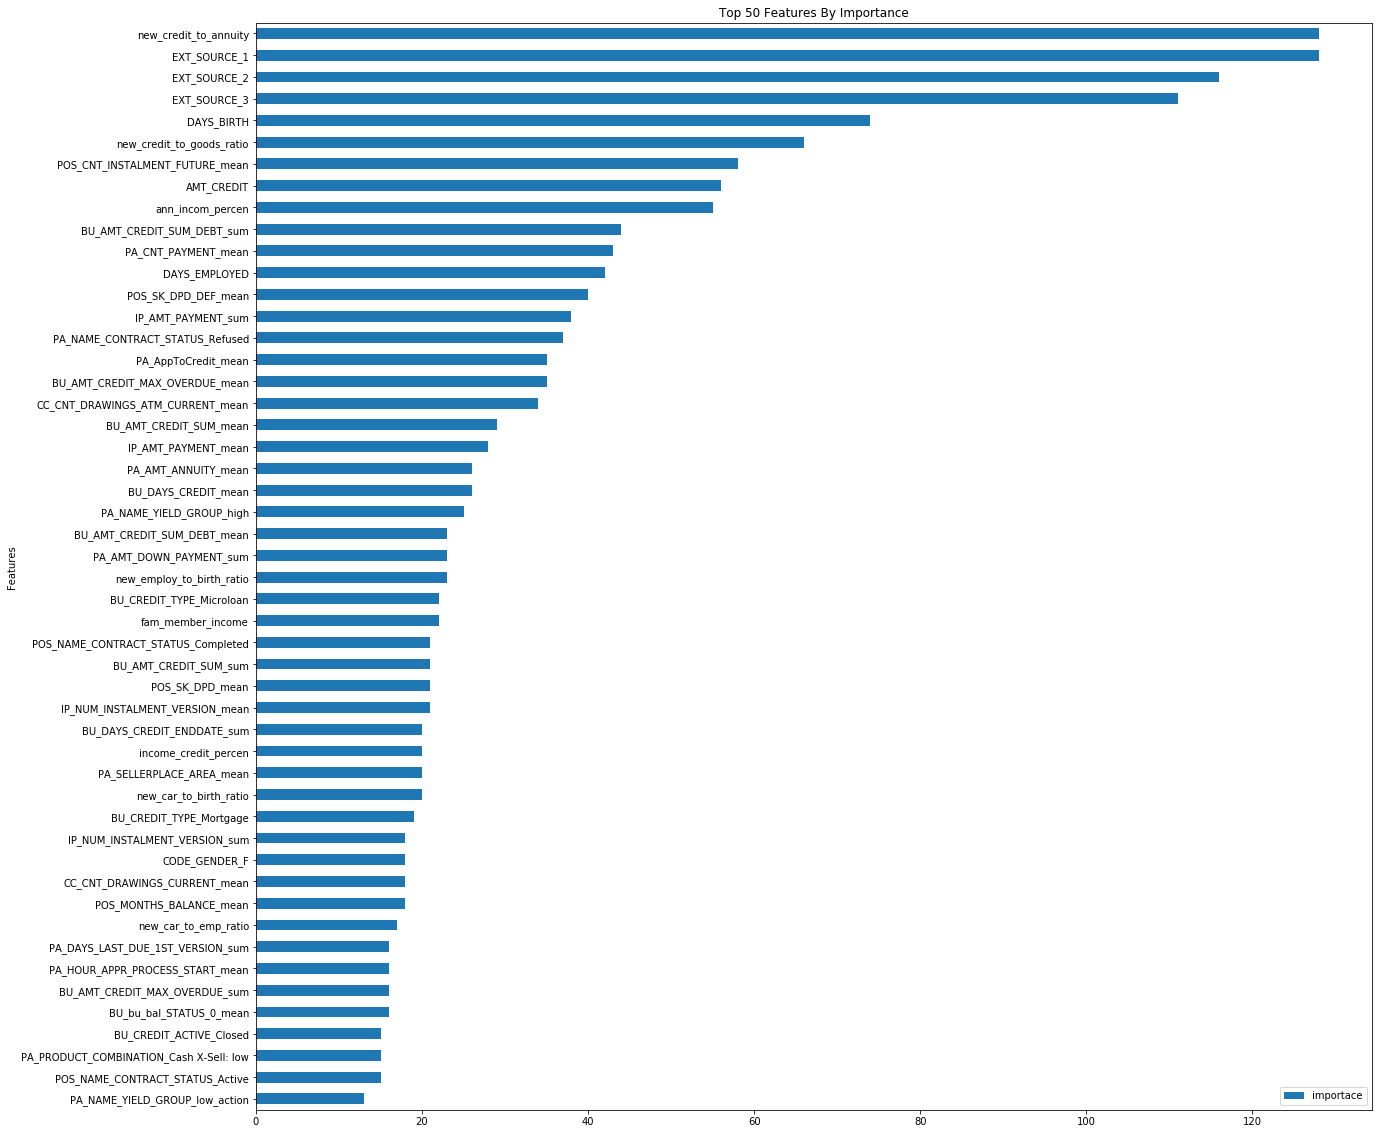

In [21]:
imp = pd.DataFrame(X_train_t.columns, columns=['Features'])
imp['importace'] = lg_model.feature_importances_
imp = imp.sort_values(by='importace', ascending=False)
imp[imp['importace'] > 0][0:50].sort_values(by='importace', ascending=True).plot(
    kind='barh', x='Features', y='importace', figsize=(20, 20), title="Top 50 Features By Importance")


## There are lots of features, lets try a feature selection model

In [22]:
feamodel = SelectFromModel(mdl, prefit=True, threshold="median")
X_train_new = feamodel.transform(X_train_t)
X_valid_new = feamodel.transform(X_valid_t)
X_test_new = feamodel.transform(X_test_t)

mdl = lg.LGBMClassifier(**params) 
mdl.fit(X_train_new , y_train
        ,eval_set=[(X_train_new , y_train),(X_test_new, y_test),(X_valid_new , y_valid)]
        ,eval_metric=['logloss', 'auc']
        ,early_stopping_rounds=100
        ,verbose=False)
expLog = update_log(expLog, 'LightGBM - With Features Selected - ',mdl, X_train_new, y_train, X_test_new, y_test, X_valid_new, y_valid)
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000
1,LightGBM - No Additional Files-,0.9318,0.9188,0.9187,0.9408,0.7547,0.7529,0.0000
2,LightGBM - All Files-,0.9221,0.9200,0.9200,0.8280,0.7792,0.7781,0.0000
3,LightGBM - With Features Selected -,0.9216,0.9201,0.9199,0.8206,0.7782,0.7787,0.0000


## We reduced about half the feature and kept the same level of accuracy. That is a win!

In [24]:
print(f" The Original Shape was {X_train_t.shape}")
print(f" The New Shape is {X_train_new.shape}")
print(f" A Reduction of {X_train_t.shape[1] - X_train_new.shape[1]} features")

 The Original Shape was (222176, 466)
 The New Shape is (222176, 243)
 A Reduction of 223 features


# Lets see if we can improve the score by hyper parameter tuning
* We did not want to use grid search as that would take a very long time. So we opted for Bayesian hyper parameter optimization via the hyperopt package

In [16]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': '{:.3f}'.format(params['subsample']),
    }

    clf = lg.LGBMClassifier(
        n_estimators=500,
        n_jobs=-1,
        **params
    )

    gbm_model = clf.fit(X_train_new, y_train
                        ,eval_set=[(X_valid_new, y_valid)]
                        ,eval_metric=['logloss', 'auc']
                        ,early_stopping_rounds=50, verbose=False)

    predictions = gbm_model.predict_proba(X_valid_new)[:, 1]
    score = roc_auc_score(y_valid, predictions)

    return {'loss': 1-score, 'status': STATUS_OK}


space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0, 0.1),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'reg_alpha': hp.quniform('reg_alpha', 0.0, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0.0, 1, 0.1),

}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)
print(best)


100%|██████████████████████████████████████████████████| 30/30 [09:13<00:00, 15.20s/it, best loss: 0.21485193362152166]
{'colsample_bytree': 0.30000000000000004, 'learning_rate': 0.07500000000000001, 'max_depth': 6.0, 'min_child_weight': 6.0, 'reg_alpha': 0.2, 'reg_lambda': 0.9, 'subsample': 0.8}


## Retraining with best parameter & optimal feature

### We good better results with the optimal hyperparameters!

In [25]:
#Score Stopps getting better after about 600 itteration. 
best = {'colsample_bytree': 0.30000000000000004
        ,'learning_rate': 0.07500000000000001
        ,'max_depth': 4
        ,'min_child_weight': 3.0
        ,'reg_alpha': 0.8
        ,'reg_lambda': 0.6000000000000001
        ,'subsample': 0.5}


best['max_depth'] = int(best['max_depth'])
mdl = lg.LGBMClassifier(n_estimators=1000, n_jobs = -1, **best) 
mdl.fit(X_train_new , y_train
        ,eval_set=[(X_train_new , y_train),(X_test_new, y_test),(X_valid_new , y_valid)]
        ,eval_metric=['logloss', 'auc']
        ,early_stopping_rounds=100
        ,verbose=False)
expLog = update_log(expLog, 'LightGBM - With Features Selected- Parameters Optimized ',mdl, X_train_new, y_train, X_test_new, y_test, X_valid_new, y_valid)
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000
1,LightGBM - No Additional Files-,0.9318,0.9188,0.9187,0.9408,0.7547,0.7529,0.0000
2,LightGBM - All Files-,0.9221,0.9200,0.9200,0.8280,0.7792,0.7781,0.0000
3,LightGBM - With Features Selected -,0.9216,0.9201,0.9199,0.8206,0.7782,0.7787,0.0000
4,LightGBM - With Features Selected- Parameters ...,0.9226,0.9198,0.9206,0.8351,0.7838,0.7841,0.0000


# Below is a final pipeline implementation of all of the above steps!

In [26]:
params = {
    'n_estimators': 600, 'learning_rate': 0.1, 'n_jobs': -1
}

best = {'colsample_bytree': 0.30000000000000004
        ,'learning_rate': 0.07500000000000001
        ,'max_depth': 4
        ,'min_child_weight': 3.0
        ,'reg_alpha': 0.8
        ,'reg_lambda': 0.6000000000000001
        ,'subsample': 0.5}

finalpipe =Pipeline([
    ('tran', transform_train(num_attribs,cat_attribs))
   ,('merge', merge_df(lst))
   ,('S_features',SelectFromModel(lg.LGBMClassifier(**params) ,prefit=False, threshold="median") )
   ,('f_model', lg.LGBMClassifier(n_estimators=600, n_jobs = -1, **best) ) 
]) 


finalpipe.fit(X_train,y_train)
expLog = update_log(expLog, 'LightGBM - Final Pipeline ',finalpipe, X_train, y_train, X_test, y_test, X_valid, y_valid)
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000
1,LightGBM - No Additional Files-,0.9318,0.9188,0.9187,0.9408,0.7547,0.7529,0.0000
2,LightGBM - All Files-,0.9221,0.9200,0.9200,0.8280,0.7792,0.7781,0.0000
3,LightGBM - With Features Selected -,0.9216,0.9201,0.9199,0.8206,0.7782,0.7787,0.0000
4,LightGBM - With Features Selected- Parameters ...,0.9226,0.9198,0.9206,0.8351,0.7838,0.7841,0.0000
5,LightGBM - Final Pipeline,0.9231,0.9198,0.9203,0.8388,0.7843,0.7830,0.0000


# Testing our model on the application_test data. 

In [27]:
load = True
if load:
    x_test  = load_main_files('application_test.csv')
    tst_ind = x_test.index
    pred = finalpipe.predict_proba(x_test)[:,1]
    sub = pd.DataFrame(tst_ind)
    sub['TARGET'] = pred
    sub.to_csv('submission.csv', index=False)

In [28]:
!kaggle competitions submissions home-credit-default-risk

fileName        date                 description                                                                                 status    publicScore  privateScore  
--------------  -------------------  ------------------------------------------------------------------------------------------  --------  -----------  ------------  
submission.csv  2019-04-27 17:30:27  Deep Learning Model- With Feature Selectio  - 30 epoc - 10 batchsize                        complete  0.76606      0.76237       
submission.csv  2019-04-27 15:36:36  Deep Learning Model- With Feature Selectio  - 30 epoc                                       complete  0.76212      0.75667       
submission.csv  2019-04-23 01:01:27  Keras Attempt 1 with Opt Features 313 start                                                 complete  0.55107      0.53958       
submission.csv  2019-04-22 22:07:24  LightGBM - Final Pipeline - Will ALL Test Data                                              complete  0.78316      0.78141      

# Attempting a Deep Learning Model!

In [36]:
def create_model():
    md2 = Sequential()
    
    sha = 233

    md2.add(Dense(sha, input_dim=sha, kernel_initializer="uniform"))
    md2.add(BatchNormalization())
    md2.add(Activation('relu'))
    md2.add(Dropout(0.2))

    md2.add(Dense(200, kernel_initializer="uniform"))
    md2.add(BatchNormalization())
    md2.add(Activation('relu'))
    md2.add(Dropout(0.2))

    md2.add(Dense(100, kernel_initializer="uniform"))
    md2.add(BatchNormalization())
    md2.add(Activation('relu'))
    md2.add(Dropout(0.2))

    md2.add(Dense(100, kernel_initializer="uniform"))
    md2.add(BatchNormalization())
    md2.add(Activation('relu'))
    md2.add(Dropout(0.2))


    md2.add(Dense(1,  kernel_initializer="uniform"))
    md2.add(BatchNormalization())
    md2.add(Activation('sigmoid'))
    
    md2.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
    return md2

md3 =KerasClassifier(build_fn=create_model, epochs=30, batch_size=10, verbose=0)


In [37]:
lst = [df_pv_app, df_pos_app, df_ins_pay, df_credit_pay, df_bureau]

finalpipe =Pipeline([
    ('tran', transform_train(num_attribs,cat_attribs))
   ,('merge', merge_df(lst))
   ,('S_features',SelectFromModel(lg.LGBMClassifier(**params) ,prefit=False, threshold="median"))
   ,('model',md3)])

finalpipe.fit(X_train,y_train)

Instructions for updating:
Use tf.cast instead.


Pipeline(memory=None,
     steps=[('tran', transform_train(cat_attribs=None, num_attribs=None)), ('merge', merge_df(dflist=[            PA_AMT_ANNUITY_sum  PA_AMT_ANNUITY_mean  PA_AMT_ANNUITY_count  \
SK_ID_CURR
100001                 -0.7748              -1.0606               -0.9273
100002                 -0.7030           ...d='median')), ('model', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000016A3993F518>)])

In [38]:
expLog = update_log(expLog, 'Deep Learning Model- With Feature Selection - pipeline  - 30 epoc - 10 batchsize ',finalpipe, X_train, y_train, X_test, y_test, X_valid, y_valid)
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,LogisticBase,0.9191,0.9193,0.9197,0.7411,0.7447,0.7487,0.0000
1,LightGBM - No Additional Files-,0.9318,0.9188,0.9187,0.9408,0.7547,0.7529,0.0000
2,LightGBM - All Files-,0.9221,0.9200,0.9200,0.8280,0.7792,0.7781,0.0000
3,LightGBM - With Features Selected -,0.9216,0.9201,0.9199,0.8206,0.7782,0.7787,0.0000
4,LightGBM - With Features Selected- Parameters ...,0.9226,0.9198,0.9206,0.8351,0.7838,0.7841,0.0000
5,LightGBM - Final Pipeline,0.9231,0.9198,0.9203,0.8388,0.7843,0.7830,0.0000
6,Deep Learning Model- With Feature Selection - ...,0.9193,0.9193,0.9193,0.8054,0.7719,0.7717,0.0000


## Deep Learning Submission

In [ ]:
load = True
if load:
    x_test  = load_main_files('application_test.csv')
    tst_ind = x_test.index
    pred = finalpipe.predict_proba(x_test)[:,1]
    sub = pd.DataFrame(tst_ind)
    sub['TARGET'] = pred
    sub.to_csv('submission.csv', index=False)

In [79]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Deep Learning Model- With Feature Selectio  - 30 epoc - 10 batchsize"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/919k [00:00<?, ?B/s]
 10%|#         | 96.0k/919k [00:00<00:00, 902kB/s]
100%|##########| 919k/919k [00:02<00:00, 414kB/s] 


In [80]:
!kaggle competitions submissions home-credit-default-risk

fileName        date                 description                                                                                 status    publicScore  privateScore  
--------------  -------------------  ------------------------------------------------------------------------------------------  --------  -----------  ------------  
submission.csv  2019-04-27 17:30:27  Deep Learning Model- With Feature Selectio  - 30 epoc - 10 batchsize                        complete  0.76606      0.76237       
submission.csv  2019-04-27 15:36:36  Deep Learning Model- With Feature Selectio  - 30 epoc                                       complete  0.76212      0.75667       
submission.csv  2019-04-23 01:01:27  Keras Attempt 1 with Opt Features 313 start                                                 complete  0.55107      0.53958       
submission.csv  2019-04-22 22:07:24  LightGBM - Final Pipeline - Will ALL Test Data                                              complete  0.78316      0.78141      